In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cmocean
import numpy as np

from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from botorch import fit_gpytorch_model

from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.datasets import make_moons

sns.set(style="white", font_scale=2.0)

In [2]:
def twospirals(n_samples, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    np.random.seed(random_state)
    
    n = np.sqrt(np.random.rand(n_samples,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_samples,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_samples,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_samples),np.ones(n_samples))))



In [3]:
# X, y = make_swiss_roll(n_samples=500, noise = 0.2, random_state=2022)
X, y = twospirals(n_samples=250, noise = 0.0, random_state=2022)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).bool()

In [4]:
~y[:10]

tensor([True, True, True, True, True, True, True, True, True, True])

In [5]:
label_flips = torch.randint(y.shape[0], (50,))
y[label_flips] = ~y[label_flips]

y = y.long()

In [6]:
test_d1 = torch.linspace(-10, 10, 20)
test_d2 = torch.linspace(-10, 10, 20)

test_x_mat, test_y_mat = torch.meshgrid(test_d1, test_d2)

test_x = torch.cat((test_x_mat.contiguous().view(-1,1), test_y_mat.contiguous().view(-1,1)),dim=1)

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
alpha_list = [0.001, 0.1, 0.25]

dirichlet_predictions = []
for alpha in alpha_list:
    likelihood = DirichletClassificationLikelihood(y, learn_additional_noise=False, alpha_epsilon=alpha)
    model = SingleTaskGP(X, likelihood.transformed_targets.t(), likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_model(mll);

    with torch.no_grad():
        post = model.posterior(test_x)
        post_samples = post.sample(torch.Size((8192,)))

        pred_probs = post_samples.exp() / post_samples.exp().sum(-1, keepdim=True)
        pred_means = pred_probs.mean(0).detach()
        pred_var = pred_probs.std(0).pow(2.0).detach()
        
        dirichlet_predictions.append([pred_means, pred_var])

In [8]:
levels = np.linspace(0., 1., 21)

## Scikit learn GPs

In [9]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

In [10]:
sklearn_gpc = GaussianProcessClassifier(Matern(length_scale=np.array([1.0, 1.0]))).fit(X.numpy(), y.numpy())

In [11]:
sklearn_probs = sklearn_gpc.predict_proba(test_x.numpy())

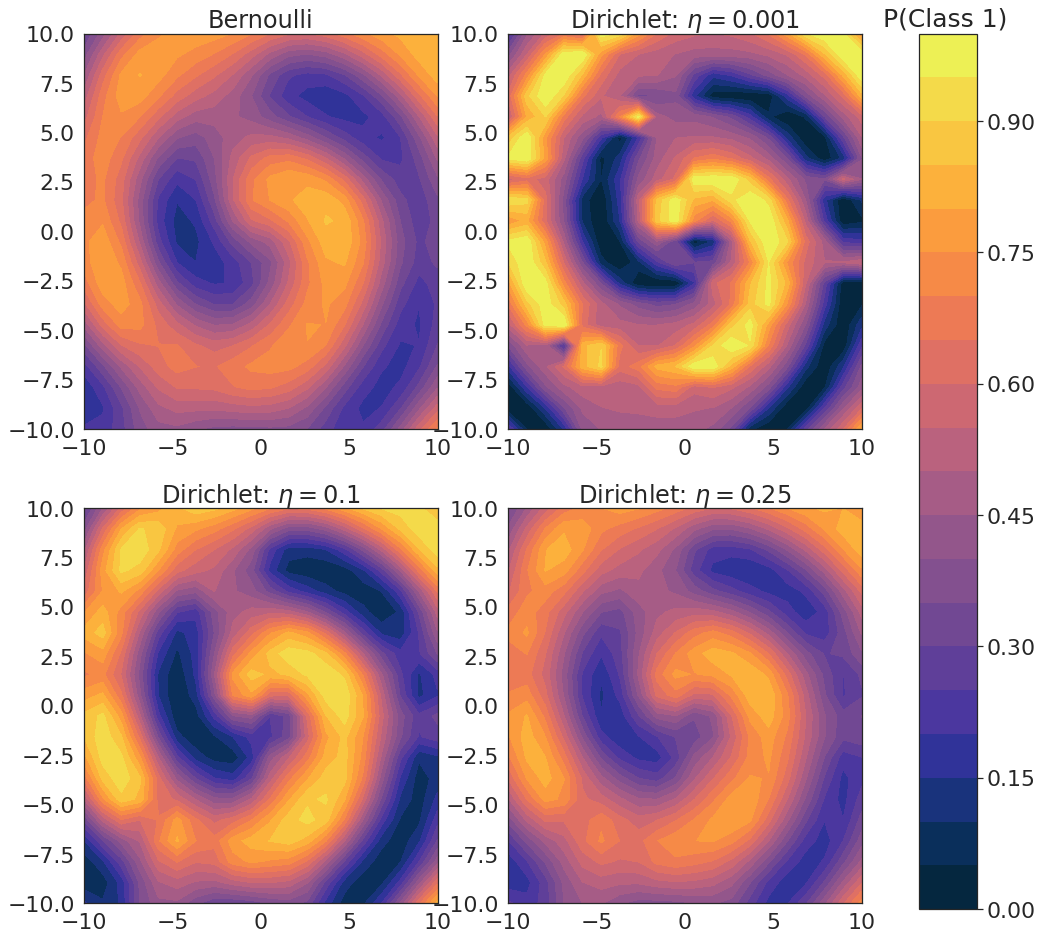

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (16, 16))
ax = ax.reshape(-1)

ax[0].contourf(
    test_x_mat, test_y_mat, sklearn_probs[...,0].reshape((20,20)),
    vmin=0., vmax=1., levels=levels, cmap=cmocean.cm.thermal
)
ax[0].set_title("Bernoulli")
    
for i in range(1, 4):
    im = ax[i].contourf(
        test_x_mat, test_y_mat, dirichlet_predictions[i-1][0][...,0].reshape((20,20)),
        vmin=0., vmax=1., levels=levels, cmap=cmocean.cm.thermal
    )
    ax[i].set_title(r'Dirichlet: $\eta = ' + str(alpha_list[i-1]) + '$')
    
# [ax[i].scatter(*X.t(), c=y, alpha = 0.2) for i in range(4)]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.76])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label='P(Class 1)',size=25, labelpad=-90, y=1.03, rotation=0)

# plt.savefig("gp_classifiers.pdf", bbox_inches = "tight")

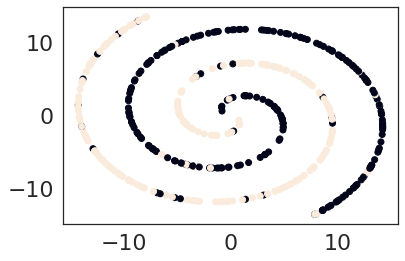

In [13]:
plt.scatter(*X.T, c=y)